In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.anova import anova_lm
from stargazer.stargazer import Stargazer

from IPython.display import display, HTML
display(HTML("<style>.container {width:85%;}</style>"))

import warnings 
display(HTML("<style>.container {width:85%;}</style>"))

# Investigating the functional form of the model(model specification)

| OLS Model Assumption                                                                                                                                                              | Implication of Violation                                                                                                       | Graphical Test                 | Test                   |
|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|-------------------------------|------------------------|
| Linear in parameters: There should be a linear relationship between the dependent variable and each of the independent variable                                               | "Misleading coefficients<br>change the functional form of the regression, which can be done by taking non-linear transformations of independent variables "     | Scatter plot of dependent vs. independent variables | RESET test |


## Data

In [36]:
path = "../data/healthgdp.csv"
df = pd.read_csv(path)

## Model

In [37]:
olsModel = smf.ols(formula = 'health ~ gdp + old65', data=df).fit()

print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:                 health   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     286.5
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           4.72e-27
Time:                        01:46:31   Log-Likelihood:                -378.51
No. Observations:                  50   AIC:                             763.0
Df Residuals:                      47   BIC:                             768.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -856.1365    219.978     -3.892      0.0

## Checking/Testing model specification
### Checking graphically

<p style="font-size: 16px">
    If the model is properly specified, Residuals vs Fitted plot will look like random noise; there won’t be any apparent patterns in the scatterplot
</p>

In [38]:
from pynometrics.pynometrics import mplot

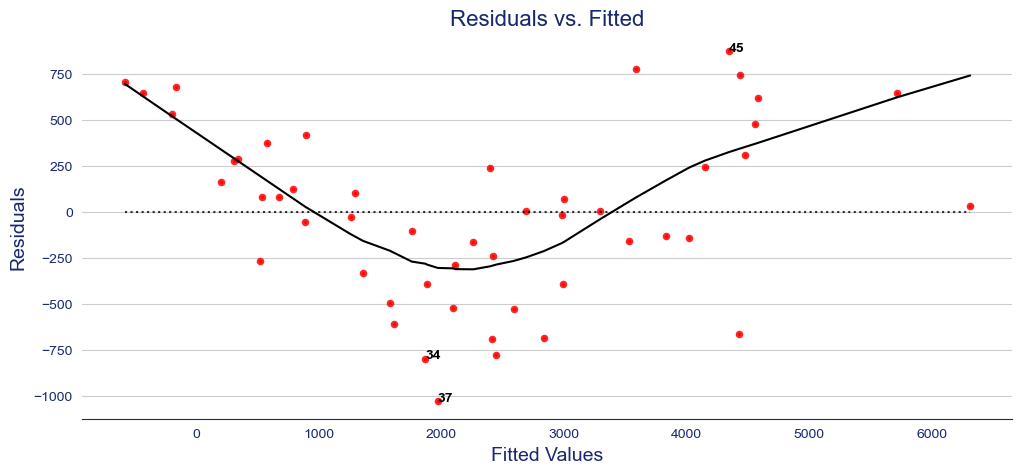

In [39]:
mplot_init = mplot(olsModel)
mplot_init.plot(1)

|Observation|
|-----------|
|The cone-shaped line suggests missing non-linear terms. |

### Regression Specification Error Test (RESET)

<p style="font-size: 16px">
    The null hypothesis is that the model with only linear terms is correctly specifiec; which is to say that coefficient of any polynomial of the fitted values if added to the model is zero
</p>

In [55]:
testResults = dg.linear_reset(olsModel, test_type = 'fitted', use_f = True)
pd.DataFrame([testResults.fvalue, testResults.pvalue], index=["f-statistic", "P-value"]).T

,f-statistic,P-value
0,33.045226,1.477594e-09


|Conclusion|
|-----------|
| We reject the null hypothesis that the current specification is correct. |

## Dealing with functional form violation

| Strategy                 | Description                                                                                                                                                                                                                                   |
|--------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Non-linear transformations | Apply non-linear transformations to the independent variables or the dependent variable to make the relationship more linear. Common transformations include logarithmic, exponential, square root, or power transformations.                |
| Polynomial regression    | Include polynomial terms (quadratic, cubic, etc.) of the independent variables in the model to capture non-linear relationships. This allows the model to have more flexibility in representing the underlying data generating process.     |
| Interaction terms        | Include interaction terms between two or more independent variables to account for non-additive relationships. This captures the joint effects of variables, which might be non-linear.                                                      |
| Piecewise linear models  | Fit different linear segments to different regions of the data, effectively allowing for different slopes in different regions. This is often referred to as piecewise linear regression.                                                 |
| Splines                  | Use flexible and smooth functions (splines) that can approximate non-linear relationships. Splines are piecewise polynomials with knots that can be placed at specific data points to capture changes in the relationship.                     |
| Data partitioning        | Partition the data and fit separate models to different partitions, each capturing a different functional form. This approach can be useful when functional form violations are specific to certain regions of the data.   |
| Model selection techniques | Use model selection techniques like stepwise regression, backward elimination, or forward selection to choose the best combination of variables and transformations that minimize the violation of the functional form. |
| Robust regression        | Consider using robust regression methods that are less sensitive to outliers or heavy-tailed errors. Robust regression can mitigate the impact of extreme observations on the model.                                             |
| Non-parametric methods   | If complex non-linear relationships are suspected, consider using non-parametric regression methods like decision trees, random forests, or support vector regression. These methods can capture intricate patterns in the data.    |


### Introducing nonlinear (polynomial) terms 

<p style="font-size: 16px">
    I transform the dependent variable and one of the independent variables using logs - other options include adding polynomials etc
</p>

In [57]:
df = (
    df
    .assign(
        log_health = lambda X: np.log(X["health"]),
        log_gdp = lambda X: np.log(X["gdp"])
    )
)


olsModelNonLinear = smf.ols(formula = 'log_health ~ log_gdp + old65', data=df).fit()

print(olsModelNonLinear.summary())

                            OLS Regression Results                            
Dep. Variable:             log_health   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     277.3
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           9.59e-27
Time:                        01:56:33   Log-Likelihood:                -3.5009
No. Observations:                  50   AIC:                             13.00
Df Residuals:                      47   BIC:                             18.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4600      0.593     -5.838      0.0

### Interpreting non-linear terms

##### Graphically

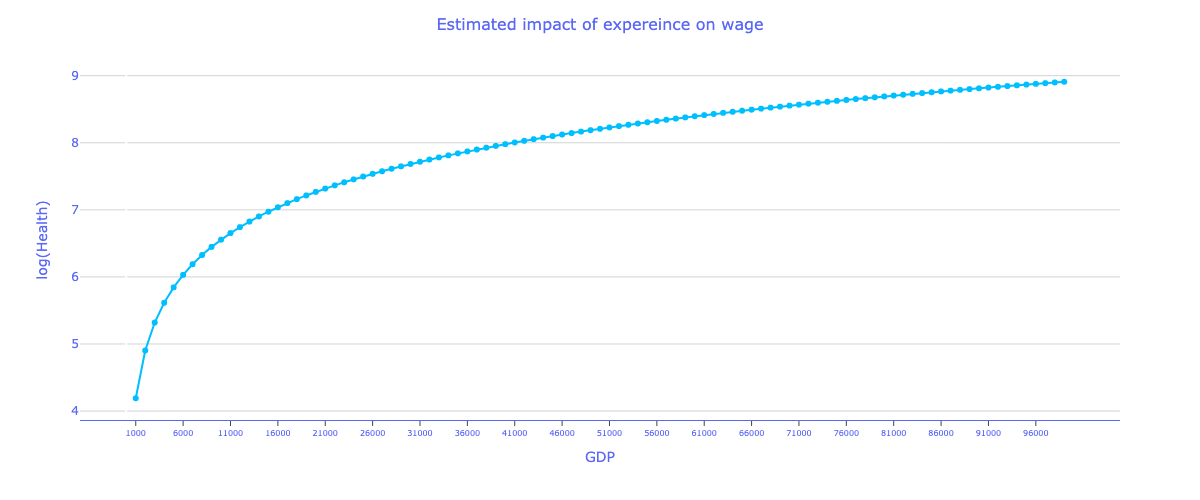

In [85]:
xs = list(range(1000, 100000, 1000))
xTicks = list(range(1000, 100000, 5000))
df_exp = (
    pd.DataFrame( {'X':xs})
    .assign(log_gdp = lambda X: np.log(X["X"]))
    .assign(
        Y = lambda X: X['log_gdp'].apply(lambda x: olsModelNonLinear.params['Intercept'] + 
                                   olsModelNonLinear.params['log_gdp']*x + 
                                   olsModelNonLinear.params['old65']*14.7 
                                  )
    )
)

fig = px.line(df_exp, x="X", y="Y", markers=True, color_discrete_sequence=["deepskyblue"])
fig.update_layout(
    width=1200,
    plot_bgcolor="white",
    font=dict(size=12, color="#5b68f6"),
    title=dict(text="Estimated impact of expereince on wage", x=0.5, xanchor="center", font=dict(size=16, color="#5b68f6")),
    yaxis=dict(showline=False, linecolor="#5b68f6", linewidth=1, showgrid=True, gridcolor="lightgray",title="log(Health)"),
    xaxis=dict(linecolor="#5b68f6", linewidth=1, showgrid=False, ticks="outside", title="GDP", tickfont=dict(size=8), tickvals=xTicks, ticktext=xTicks),
    legend=dict(orientation="h", x=0.5, y=1.01)
)
fig.show("png")

#### Getting marginal effects